## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [48]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

from sklearn import preprocessing

# Privacy Meter
from privacy_meter.dataset import Dataset

from aif360.datasets import BinaryLabelDataset

In [49]:
import os
import shutil
import glob

## Arguments & Initializations

In [50]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [51]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [52]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [53]:
DATASET = "bank"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia1"

In [54]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [55]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [56]:
dataset_orig.features.shape

(30448, 57)

In [57]:
privileged_groups

[{'age': 1}]

In [58]:
sens_attr

'age'

In [59]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [60]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[  1. 236.   3. ...   0.   1.   0.]
 [  1. 137.   1. ...   0.   1.   0.]
 [  1. 218.   1. ...   1.   0.   0.]
 ...
 [  1. 329.   4. ...   0.   1.   0.]
 [  1. 120.   6. ...   0.   1.   0.]
 [  1. 245.   1. ...   0.   1.   0.]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [61]:
seed = 1234
np.random.seed(seed)

In [62]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [63]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [64]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [65]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features

    print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [66]:
def delete_logs():
    # Search for directories ending with _group reor _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [67]:
target_dataset = None
reference_dataset = None

In [68]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

# run mitigating algorithms
for i in range(N):
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

        print("#### Train dataset's features are as below:")
        print(dataset_orig_train.features)
    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()
        
        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2
        
        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)
        
        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Convert test dataset
        dataset_orig_val = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Since validation and testing datasets are the same
        dataset_orig_test = dataset_orig_val
        
        # orig_metrics, orig_mia_metrics, priv_metric_orig, favor_metric_orig = run_MIA2(dataset_orig, target_dataset, reference_dataset, privileged_groups, unprivileged_groups, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, SCALER)
        
    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig.favorable_label
    uf_label = dataset_orig.unfavorable_label
    feature_names = dataset_orig.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

    # eg mitigator, in-processing
    eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # egr gave error so I replaced it with reweigh
# #     eg_metrics, eg_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, eg_metrics, eg_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

#     # cpp mitigator
#     cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     # ro mitigator
#     # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     if (BASELINE == 'lr'):
#         pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    delete_logs()

#### Train dataset's features are as below:
[[  1. 137.   7. ...   1.   0.   0.]
 [  1. 345.   1. ...   0.   1.   0.]
 [  1.  51.  33. ...   0.   1.   0.]
 ...
 [  1. 465.   4. ...   0.   1.   0.]
 [  0.  97.   2. ...   0.   1.   0.]
 [  1. 381.   4. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(15224, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'educatio

RUN DIRMITIGATOR
[INFO]: training decision tree
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 607
Number of test samples (ntest): 565
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 309
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12695
Number of test samples (ntest): 12723
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1659
Number of test samples (ntest): 1627
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13302
         1.0       0.80      0.74      0.77      1922

    accuracy                           0.94     15224
   macro avg       0.88      0.86      0.87     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9444298476090384
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.12
Testing Origin

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 607
Number of test samples (ntest): 565
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 263
Number of test samples (ntest): 309
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12695
Number of test samples (ntest): 12723
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1659
Number of test samples (ntest): 1627
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13302
         1.0       0.76      0.62      0.68      1922

    accuracy                           0.93     15224
   macro avg       0.85      0.80      0.82     15224
weighted avg       0.92      0.93      0.92     15224

Train accuracy:  0.9267603783499737
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.13860520827321576
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13302, Test = 13288
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.13860520827321576
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1922, Test = 1936
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.15
  Positive predictive value: 0.59
  Optimal thershold: -0.15666412539462074
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 572
Number of test samples (ntest): 600
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 255
Number of test samples (ntest): 317
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12687
Number of test samples (ntest): 12731
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1710
Number of test samples (ntest): 1576
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13259
         1.0       0.83      0.73      0.78      1965

    accuracy                           0.95     15224
   macro avg       0.89      0.86      0.87     15224
weighted avg       0.94      0.95      0.94     15224

Train accuracy:  0.9457435627955859
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.03
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

Best thresh:  0.13
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.07
  Positive predictive value: 0.52
  Optimal thershold: -0.8266785731844679
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13259, Test = 13331
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: -0.0775582343458745
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1965, Test = 1893
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.18
  Positive predictive value: 0.61
  Optimal thershold: -0.8979415932059586
)
MIA_Result(
  Name: subpop

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 572
Number of test samples (ntest): 600
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 255
Number of test samples (ntest): 317
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12687
Number of test samples (ntest): 12731
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1710
Number of test samples (ntest): 1576
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13259
         1.0       0.74      0.62      0.68      1965

    accuracy                           0.92     15224
   macro avg       0.84      0.79      0.82     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9231476615869679
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.021244424110043576
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13259, Test = 13331
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1965, Test = 1893
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.57
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.13
  Positive predictive value: 0.58
  Optimal thershold: -0.9515876845794916
)
MIA_Result(
  Name: subpopu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 590
Number of test samples (ntest): 582
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 299
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12667
Number of test samples (ntest): 12751
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1668
Number of test samples (ntest): 1618
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13257
         1.0       0.80      0.71      0.75      1967

    accuracy                           0.94     15224
   macro avg       0.88      0.84      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9393720441408303
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.09
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Na

Best thresh:  0.11
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.15
  Positive predictive value: 0.58
  Optimal thershold: -0.0953101798043249
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13257, Test = 13333
  AUC: 0.57
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.15
  Positive predictive value: 0.56
  Optimal thershold: -0.0953101798043249
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1967, Test = 1891
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.17
  Positive predictive value: 0.64
  Optimal thershold: -0.587786664902119
)
MIA_Result(
  Name: subpopu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 590
Number of test samples (ntest): 582
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 299
Number of test samples (ntest): 273
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12667
Number of test samples (ntest): 12751
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1668
Number of test samples (ntest): 1618
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     13257
         1.0       0.72      0.63      0.67      1967

    accuracy                           0.92     15224
   macro avg       0.83      0.80      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9204545454545454
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.2567166596097514
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13257, Test = 13333
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.05407292118641707
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1967, Test = 1891
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.13
  Positive predictive value: 0.59
  Optimal thershold: -0.19088893203051757
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 593
Number of test samples (ntest): 579
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 274
Number of test samples (ntest): 298
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12703
Number of test samples (ntest): 12715
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1654
Number of test samples (ntest): 1632
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13296
         1.0       0.82      0.73      0.77      1928

    accuracy                           0.94     15224
   macro avg       0.89      0.85      0.87     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9446269048870205
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
M

Best thresh:  0.060000000000000005
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.55
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.07
  Positive predictive value: 0.60
  Optimal thershold: -0.0012195123462612543
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13296, Test = 13294
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.06
  Positive predictive value: 0.58
  Optimal thershold: -0.0012195123462612543
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1928, Test = 1930
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.19
  Positive predictive value: 0.64
  Optimal thershold: -1.3581234841531944
)
MIA_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 593
Number of test samples (ntest): 579
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 274
Number of test samples (ntest): 298
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12703
Number of test samples (ntest): 12715
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1654
Number of test samples (ntest): 1632
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     13296
         1.0       0.70      0.64      0.67      1928

    accuracy                           0.92     15224
   macro avg       0.83      0.80      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9204545454545454
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -0.05177649668004134
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13296, Test = 13294
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: -0.05177649668004134
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1928, Test = 1930
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.11
  Positive predictive value: 0.56
  Optimal thershold: -0.05177649668004122
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 607
Number of test samples (ntest): 565
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 284
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12667
Number of test samples (ntest): 12751
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1662
Number of test samples (ntest): 1624
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     13274
         1.0       0.83      0.68      0.75      1950

    accuracy                           0.94     15224
   macro avg       0.89      0.83      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.94088281660536
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.11
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name

Best thresh:  0.060000000000000005
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.06
  Positive predictive value: 0.58
  Optimal thershold: -0.6061358035703156
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13274, Test = 13316
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: -0.10536051565782628
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1950, Test = 1908
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.22
  Positive predictive value: 0.63
  Optimal thershold: -0.6931471805599453
)
MIA_Resul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 607
Number of test samples (ntest): 565
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 284
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12667
Number of test samples (ntest): 12751
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1662
Number of test samples (ntest): 1624
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     13274
         1.0       0.75      0.61      0.67      1950

    accuracy                           0.92     15224
   macro avg       0.85      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9235417761429322
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.5537336239530936
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13274, Test = 13316
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.40547365931234985
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1950, Test = 1908
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.11
  Positive predictive value: 0.57
  Optimal thershold: -0.5537336239530936
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 590
Number of test samples (ntest): 582
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 273
Number of test samples (ntest): 299
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12756
Number of test samples (ntest): 12662
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1605
Number of test samples (ntest): 1681
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13346
         1.0       0.79      0.75      0.77      1878

    accuracy                           0.94     15224
   macro avg       0.88      0.86      0.87     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9441014188124015
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
M

Best thresh:  0.08
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.49
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: -0.48550781578170077
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13346, Test = 13244
  AUC: 0.47
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.09
  Positive predictive value: 0.51
  Optimal thershold: -0.4769240720903093
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1878, Test = 1980
  AUC: 0.66
  Privacy Risk: 0.63
  Accuracy: 0.63
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.26
  Positive predictive value: 0.62
  Optimal thershold: -0.7731898882334817
)
MIA_Result(
  Name: subpo

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 590
Number of test samples (ntest): 582
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 273
Number of test samples (ntest): 299
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12756
Number of test samples (ntest): 12662
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1605
Number of test samples (ntest): 1681
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13346
         1.0       0.74      0.60      0.66      1878

    accuracy                           0.92     15224
   macro avg       0.84      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9248554913294798
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.06561747738535295
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13346, Test = 13244
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.06561747738535295
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1878, Test = 1980
  AUC: 0.57
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.11
  Positive predictive value: 0.56
  Optimal thershold: -0.09152553149613277
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 567
Number of test samples (ntest): 605
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 275
Number of test samples (ntest): 297
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12750
Number of test samples (ntest): 12668
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1632
Number of test samples (ntest): 1654
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13317
         1.0       0.80      0.70      0.75      1907

    accuracy                           0.94     15224
   macro avg       0.88      0.84      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9408171308460326
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.08
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Na

Best thresh:  0.05
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.47
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.09
  Positive predictive value: 0.52
  Optimal thershold: -0.8472978603872037
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13317, Test = 13273
  AUC: 0.44
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.11
  Positive predictive value: 0.52
  Optimal thershold: -0.916290731874155
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1907, Test = 1951
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.21
  Positive predictive value: 0.62
  Optimal thershold: -1.3545456628053103
)
MIA_Result(
  Name: subpopu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 567
Number of test samples (ntest): 605
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 275
Number of test samples (ntest): 297
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12750
Number of test samples (ntest): 12668
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1632
Number of test samples (ntest): 1654
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     13317
         1.0       0.72      0.64      0.68      1907

    accuracy                           0.92     15224
   macro avg       0.84      0.80      0.82     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9247898055701524
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.5203047365380061
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13317, Test = 13273
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.5203047365380061
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1907, Test = 1951
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.14
  Positive predictive value: 0.57
  Optimal thershold: -0.7015825967630438
)
MIA_Result(


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 569
Number of test samples (ntest): 603
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 301
Number of test samples (ntest): 271
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12737
Number of test samples (ntest): 12681
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1617
Number of test samples (ntest): 1669
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13306
         1.0       0.81      0.72      0.76      1918

    accuracy                           0.94     15224
   macro avg       0.89      0.85      0.87     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9437729900157645
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
M

TEST
POS IND 1
NEG IND 0
Best thresh:  0.03
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.05
  Positive predictive value: 0.57
  Optimal thershold: -0.5596157879354228
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13306, Test = 13284
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.04
  Positive predictive value: 0.55
  Optimal thershold: -0.012658396871923465
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1918, Test = 1940
  AUC: 0.63
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.21
  Positive predictive value: 0.61
  Optimal thershold: -1.001448540214462
)


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 569
Number of test samples (ntest): 603
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 301
Number of test samples (ntest): 271
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12737
Number of test samples (ntest): 12681
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1617
Number of test samples (ntest): 1669
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13306
         1.0       0.72      0.61      0.66      1918

    accuracy                           0.92     15224
   macro avg       0.83      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.921242774566474
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.06947731273777998
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13306, Test = 13284
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1918, Test = 1940
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.14
  Positive predictive value: 0.59
  Optimal thershold: -0.06947731273777998
)
MIA_Result(
  Name: subpopu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 569
Number of test samples (ntest): 603
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 305
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12752
Number of test samples (ntest): 12666
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1636
Number of test samples (ntest): 1650
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13321
         1.0       0.78      0.75      0.76      1903

    accuracy                           0.94     15224
   macro avg       0.87      0.86      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9415396741986337
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.09
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Na

Best thresh:  0.18000000000000002
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: -0.003613373398513815
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13321, Test = 13269
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.07
  Positive predictive value: 0.53
  Optimal thershold: -0.003613373398513815
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1903, Test = 1955
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.18
  Positive predictive value: 0.63
  Optimal thershold: -0.8472978603872037
)
MIA_Res

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 569
Number of test samples (ntest): 603
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 267
Number of test samples (ntest): 305
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12752
Number of test samples (ntest): 12666
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1636
Number of test samples (ntest): 1650
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13321
         1.0       0.75      0.61      0.67      1903

    accuracy                           0.93     15224
   macro avg       0.85      0.79      0.82     15224
weighted avg       0.92      0.93      0.92     15224

Train accuracy:  0.925775091960063
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13321, Test = 13269
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1903, Test = 1955
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.15
  Positive predictive value: 0.58
  Optimal thershold: -0.8595616597138596
)
MIA_Re

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 585
Number of test samples (ntest): 587
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 290
Number of test samples (ntest): 282
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12732
Number of test samples (ntest): 12686
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1617
Number of test samples (ntest): 1669
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13317
         1.0       0.82      0.70      0.75      1907

    accuracy                           0.94     15224
   macro avg       0.89      0.84      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9429190751445087
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.09
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Na

Best thresh:  0.060000000000000005
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.05
  Positive predictive value: 0.65
  Optimal thershold: -0.40546510810816444
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13317, Test = 13273
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.09
  Test Accuracy (TNR): 0.95
  Attacker advantage: 0.04
  Positive predictive value: 0.65
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1907, Test = 1951
  AUC: 0.66
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.22
  Positive predictive value: 0.65
  Optimal thershold: -0.40546510810816444
)
MIA_R

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 585
Number of test samples (ntest): 587
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 290
Number of test samples (ntest): 282
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12732
Number of test samples (ntest): 12686
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1617
Number of test samples (ntest): 1669
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13317
         1.0       0.74      0.61      0.67      1907

    accuracy                           0.92     15224
   macro avg       0.84      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9249211770888072
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.39737149767883484
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13317, Test = 13273
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1907, Test = 1951
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.12
  Positive predictive value: 0.56
  Optimal thershold: -0.39737149767883484
)
MIA_Result(
  Name: subpopu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 588
Number of test samples (ntest): 584
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 284
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12683
Number of test samples (ntest): 12735
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1665
Number of test samples (ntest): 1621
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13271
         1.0       0.81      0.73      0.77      1953

    accuracy                           0.94     15224
   macro avg       0.89      0.85      0.87     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9436416184971098
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
M

Best thresh:  0.09
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.58
  Optimal thershold: -0.8685958580661379
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13271, Test = 13319
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.56
  Optimal thershold: -0.09763846956391593
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1953, Test = 1905
  AUC: 0.64
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.20
  Positive predictive value: 0.64
  Optimal thershold: -0.7884573603642702
)
MIA_Result(
  Name: subpo

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 588
Number of test samples (ntest): 584
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 284
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12683
Number of test samples (ntest): 12735
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1665
Number of test samples (ntest): 1621
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     13271
         1.0       0.67      0.64      0.65      1953

    accuracy                           0.91     15224
   macro avg       0.81      0.80      0.80     15224
weighted avg       0.91      0.91      0.91     15224

Train accuracy:  0.9132947976878613
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.02
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -0.06233093684155566
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13271, Test = 13319
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.55
  Optimal thershold: -0.013060668522163239
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1953, Test = 1905
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.14
  Positive predictive value: 0.58
  Optimal thershold: -3.048029112965268
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 555
Number of test samples (ntest): 617
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 282
Number of test samples (ntest): 290
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12765
Number of test samples (ntest): 12653
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1622
Number of test samples (ntest): 1664
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13320
         1.0       0.82      0.74      0.78      1904

    accuracy                           0.95     15224
   macro avg       0.89      0.86      0.87     15224
weighted avg       0.95      0.95      0.95     15224

Train accuracy:  0.9471886495007882
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.08
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Na

Best thresh:  0.12
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.08
  Positive predictive value: 0.53
  Optimal thershold: -0.009049835519917927
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13320, Test = 13270
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.07
  Positive predictive value: 0.53
  Optimal thershold: -0.009049835519917927
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1904, Test = 1954
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.16
  Positive predictive value: 0.60
  Optimal thershold: -0.7621400520468967
)
MIA_Result(
  Name: su

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 555
Number of test samples (ntest): 617
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 282
Number of test samples (ntest): 290
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12765
Number of test samples (ntest): 12653
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1622
Number of test samples (ntest): 1664
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     13320
         1.0       0.70      0.61      0.65      1904

    accuracy                           0.92     15224
   macro avg       0.82      0.79      0.80     15224
weighted avg       0.91      0.92      0.92     15224

Train accuracy:  0.9184182869153967
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0.008069492125443146
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13320, Test = 13270
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.008069492125443035
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1904, Test = 1954
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.47
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.09
  Positive predictive value: 0.55
  Optimal thershold: -0.008069492125443146
)
MIA_Result(
  Name: subpop

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 561
Number of test samples (ntest): 611
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 286
Number of test samples (ntest): 286
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12701
Number of test samples (ntest): 12717
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1676
Number of test samples (ntest): 1610
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13262
         1.0       0.83      0.71      0.76      1962

    accuracy                           0.94     15224
   macro avg       0.89      0.84      0.87     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9436416184971098
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.060000000000000005
Testing Original ...
TEST
POS IND 1
NEG IND 0


Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.10
  Positive predictive value: 0.53
  Optimal thershold: -0.1809431968238333
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13262, Test = 13328
  AUC: 0.52
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.19
  Attacker advantage: 0.10
  Positive predictive value: 0.53
  Optimal thershold: -0.1809431968238333
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1962, Test = 1896
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.14
  Positive predictive value: 0.59
  Optimal thershold: -1.798679912072629
)
MIA_Result(


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 561
Number of test samples (ntest): 611
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 286
Number of test samples (ntest): 286
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12701
Number of test samples (ntest): 12717
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1676
Number of test samples (ntest): 1610
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     13262
         1.0       0.73      0.66      0.69      1962

    accuracy                           0.92     15224
   macro avg       0.84      0.81      0.82     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9246584340514976
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -0.15102551907472256
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13262, Test = 13328
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.02
  Positive predictive value: 0.53
  Optimal thershold: -0.15102551907472256
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1962, Test = 1896
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.55
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.11
  Positive predictive value: 0.56
  Optimal thershold: -0.001087711062711415
)
MIA_Resu

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 570
Number of test samples (ntest): 602
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 284
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12735
Number of test samples (ntest): 12683
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1631
Number of test samples (ntest): 1655
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13305
         1.0       0.84      0.68      0.75      1919

    accuracy                           0.94     15224
   macro avg       0.90      0.83      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9436416184971098
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
M

Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.57
  Optimal thershold: -0.587786664902119
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13305, Test = 13285
  AUC: 0.49
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.04
  Positive predictive value: 0.55
  Optimal thershold: -0.587786664902119
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1919, Test = 1939
  AUC: 0.65
  Privacy Risk: 0.62
  Accuracy: 0.61
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.23
  Positive predictive value: 0.61
  Optimal thershold: -0.916290731874155
)
MIA_Result(
  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 570
Number of test samples (ntest): 602
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 284
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12735
Number of test samples (ntest): 12683
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1631
Number of test samples (ntest): 1655
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     13305
         1.0       0.73      0.61      0.66      1919

    accuracy                           0.92     15224
   macro avg       0.84      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9226878612716763
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.6556998550185605
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13305, Test = 13285
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.02774102331376021
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1919, Test = 1939
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.14
  Positive predictive value: 0.58
  Optimal thershold: -0.6556998550185605
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 619
Number of test samples (ntest): 553
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 282
Number of test samples (ntest): 290
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12652
Number of test samples (ntest): 12766
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1671
Number of test samples (ntest): 1615
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13271
         1.0       0.80      0.71      0.76      1953

    accuracy                           0.94     15224
   macro avg       0.88      0.84      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9411455596426694
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.11
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Na

Best thresh:  0.27
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.14
  Positive predictive value: 0.57
  Optimal thershold: -0.007272759329079809
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13271, Test = 13319
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.15
  Positive predictive value: 0.56
  Optimal thershold: -0.007272759329079809
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1953, Test = 1905
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.19
  Positive predictive value: 0.65
  Optimal thershold: -0.40546510810816444
)
MIA_Result(
  Name: s

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 619
Number of test samples (ntest): 553
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 282
Number of test samples (ntest): 290
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12652
Number of test samples (ntest): 12766
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1671
Number of test samples (ntest): 1615
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13271
         1.0       0.74      0.62      0.68      1953

    accuracy                           0.92     15224
   macro avg       0.84      0.80      0.82     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9234760903836048
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13271, Test = 13319
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1953, Test = 1905
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.13
  Positive predictive value: 0.59
  Optimal thershold: -0.1656952064062282
)
MIA_Re

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 584
Number of test samples (ntest): 588
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 303
Number of test samples (ntest): 269
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12715
Number of test samples (ntest): 12703
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1622
Number of test samples (ntest): 1664
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13299
         1.0       0.80      0.73      0.76      1925

    accuracy                           0.94     15224
   macro avg       0.88      0.85      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9419994745139254
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
M

TEST
POS IND 1
NEG IND 0
Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: -0.060624621816434854
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13299, Test = 13291
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.06
  Positive predictive value: 0.53
  Optimal thershold: -0.060624621816434854
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1925, Test = 1933
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.19
  Positive predictive value: 0.64
  Optimal thershold: -0.9

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 584
Number of test samples (ntest): 588
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 303
Number of test samples (ntest): 269
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12715
Number of test samples (ntest): 12703
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1622
Number of test samples (ntest): 1664
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     13299
         1.0       0.72      0.61      0.66      1925

    accuracy                           0.92     15224
   macro avg       0.83      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9205202312138728
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.00058050207416079
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13299, Test = 13291
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1925, Test = 1933
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.14
  Positive predictive value: 0.58
  Optimal thershold: -0.00058050207416079
)
MIA_Res

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 587
Number of test samples (ntest): 585
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 294
Number of test samples (ntest): 278
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12701
Number of test samples (ntest): 12717
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1642
Number of test samples (ntest): 1644
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     13288
         1.0       0.82      0.67      0.73      1936

    accuracy                           0.94     15224
   macro avg       0.88      0.82      0.85     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9385181292695743
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.03
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Na

POS IND 1
NEG IND 0
Best thresh:  0.08
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.06
  Positive predictive value: 0.58
  Optimal thershold: -0.8135108628098204
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13288, Test = 13302
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: -0.11954515064978269
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1936, Test = 1922
  AUC: 0.64
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.21
  Positive predictive value: 0.65
  Optimal thershold: -0.8135108628098204
)
MIA_R

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 587
Number of test samples (ntest): 585
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 294
Number of test samples (ntest): 278
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12701
Number of test samples (ntest): 12717
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1642
Number of test samples (ntest): 1644
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     13288
         1.0       0.75      0.59      0.66      1936

    accuracy                           0.92     15224
   macro avg       0.84      0.78      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9222937467157121
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.0994844480511358
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13288, Test = 13302
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1936, Test = 1922
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.60
  Attacker advantage: 0.12
  Positive predictive value: 0.58
  Optimal thershold: -0.0994844480511358
)
MIA_Resul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 589
Number of test samples (ntest): 583
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 266
Number of test samples (ntest): 306
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12720
Number of test samples (ntest): 12698
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1649
Number of test samples (ntest): 1637
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     13309
         1.0       0.76      0.76      0.76      1915

    accuracy                           0.94     15224
   macro avg       0.86      0.86      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9391093011035208
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.08
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

Best thresh:  0.08
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.06
  Positive predictive value: 0.58
  Optimal thershold: -0.008613317678114947
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13309, Test = 13281
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.05
  Positive predictive value: 0.57
  Optimal thershold: -0.008613317678114947
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1915, Test = 1943
  AUC: 0.64
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.20
  Positive predictive value: 0.64
  Optimal thershold: -0.916290731874155
)
MIA_Result(
  Name: sub

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 589
Number of test samples (ntest): 583
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 266
Number of test samples (ntest): 306
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12720
Number of test samples (ntest): 12698
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1649
Number of test samples (ntest): 1637
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13309
         1.0       0.72      0.61      0.66      1915

    accuracy                           0.92     15224
   macro avg       0.83      0.79      0.81     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.920717288491855
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13309, Test = 13281
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.07
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.18182587864923708
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1915, Test = 1943
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.40
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.15
  Positive predictive value: 0.61
  Optimal thershold: -9.992007221626415e-16
)
MIA_R

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 590
Number of test samples (ntest): 582
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 284
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12679
Number of test samples (ntest): 12739
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1667
Number of test samples (ntest): 1619
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13269
         1.0       0.81      0.70      0.76      1955

    accuracy                           0.94     15224
   macro avg       0.89      0.84      0.86     15224
weighted avg       0.94      0.94      0.94     15224

Train accuracy:  0.9413426169206516
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
M

Best thresh:  0.06999999999999999
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -1.0473189942805592
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13269, Test = 13321
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -1.0127808528183286
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1955, Test = 1903
  AUC: 0.64
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.21
  Positive predictive value: 0.65
  Optimal thershold: -0.7884573603642702
)
MIA_Result(

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 590
Number of test samples (ntest): 582
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 288
Number of test samples (ntest): 284
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12679
Number of test samples (ntest): 12739
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1667
Number of test samples (ntest): 1619
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13269
         1.0       0.74      0.64      0.68      1955

    accuracy                           0.92     15224
   macro avg       0.84      0.80      0.82     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.924724119810825
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.07073607624417012
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13269, Test = 13321
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1955, Test = 1903
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.14
  Positive predictive value: 0.59
  Optimal thershold: -0.07073607624417012
)
MIA_Res

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 618
Number of test samples (ntest): 554
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 268
Number of test samples (ntest): 304
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12739
Number of test samples (ntest): 12679
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1599
Number of test samples (ntest): 1687
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     13357
         1.0       0.82      0.70      0.76      1867

    accuracy                           0.95     15224
   macro avg       0.89      0.84      0.86     15224
weighted avg       0.94      0.95      0.94     15224

Train accuracy:  0.9450867052023122
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.08
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Na

TEST
POS IND 1
NEG IND 0
Best thresh:  0.05
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -0.7672551527136672
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13357, Test = 13233
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.39086630868701167
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1867, Test = 1991
  AUC: 0.64
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.19
  Positive predictive value: 0.61
  Optimal thershold: -0.7672551527136672
)


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 618
Number of test samples (ntest): 554
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 268
Number of test samples (ntest): 304
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 12739
Number of test samples (ntest): 12679
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1599
Number of test samples (ntest): 1687
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96     13357
         1.0       0.74      0.57      0.64      1867

    accuracy                           0.92     15224
   macro avg       0.84      0.77      0.80     15224
weighted avg       0.92      0.92      0.92     15224

Train accuracy:  0.9226221755123489
Validating EG ...
TEST


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0
Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15224, Test = 15224
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: -0.057840825133567364
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13357, Test = 13233
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.56
  Optimal thershold: -0.003357552805895322
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1867, Test = 1991
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.13
  Positive predictive value: 0.56
  Optimal thershold: -0.057840825133567364
)
MIA_Re

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [69]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [70]:
df_bank['age'].value_counts()

age
1.0    28704
0.0     1744
Name: count, dtype: int64

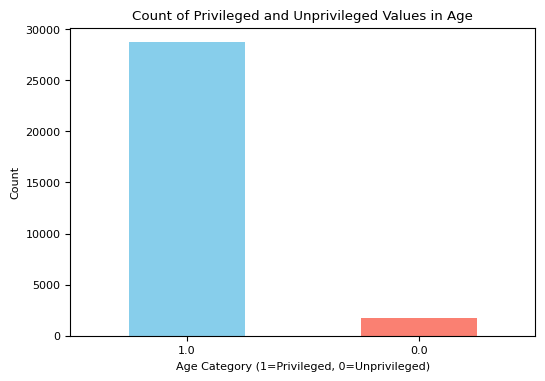

In [71]:
# Count the occurrences of privileged and unprivileged values
age_counts = df_bank['age'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Age')
plt.xlabel('Age Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [72]:
y_counts = df_bank['y'].value_counts()

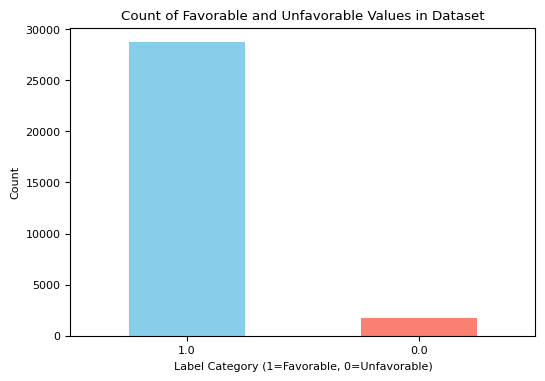

In [73]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [74]:
df_bank.shape

(30448, 58)

## Display Output

In [75]:
priv_metric_orig_copy = priv_metric_orig

In [76]:

priv_metric_orig_copy

defaultdict(float, {'total_priv': 287140.0, 'total_unpriv': 17340.0})

In [77]:
priv_metric_orig

defaultdict(float, {'total_priv': 287140.0, 'total_unpriv': 17340.0})

In [78]:
priv_metric_orig.items()

dict_items([('total_priv', 287140.0), ('total_unpriv', 17340.0)])

In [79]:
priv_metric_orig = priv_metric_orig_copy

In [80]:
orig_metrics.items()

dict_items([('bal_acc', [0.8265198265010125, 0.8321907997924993, 0.8394620362600551, 0.8260815779606835, 0.8294669863275088, 0.8253221584616933, 0.8263485879447658, 0.8241204829001325, 0.8307480524476893, 0.8458734898944119, 0.8301945063384082, 0.8377242516076234, 0.825445368020626, 0.8245917107068564, 0.8336273896013018, 0.8312555711512869, 0.8346384033696669, 0.838448856951388, 0.8200210194429847, 0.834151645831011]), ('avg_odds_diff', [0.1299023504661376, 0.09248720935179763, 0.14664648239957684, 0.12227971349962427, 0.13764823894838613, 0.12460202171905106, 0.09950779379072028, 0.16761618321913307, 0.1319829469415168, 0.13013279589255566, 0.14879925395012855, 0.16369778894540649, 0.1330070777780789, 0.08906125963145495, 0.13901348231728658, 0.13891137927041186, 0.13685912480568235, 0.1371732319270479, 0.133328466456615, 0.1368852855006841]), ('disp_imp', [0.5776703039913205, 0.5479048717411058, 0.6079263329571207, 0.5801136704324474, 0.6146074133440192, 0.584716580372356, 0.5525822

In [81]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

bank
15224
2)

              total_priv  total_unpriv
num_instance                          
orig             14357.0         867.0
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.126557       0.873443    0.114592      0.885408      0.324672   
transf      0.114593       0.885407    0.114592      0.885408      0.114593   

         unpriv_unfavor  
dataset                  
orig           0.675328  
transf         0.885407  


In [82]:
orig_metrics.items()

dict_items([('bal_acc', [0.8265198265010125, 0.8321907997924993, 0.8394620362600551, 0.8260815779606835, 0.8294669863275088, 0.8253221584616933, 0.8263485879447658, 0.8241204829001325, 0.8307480524476893, 0.8458734898944119, 0.8301945063384082, 0.8377242516076234, 0.825445368020626, 0.8245917107068564, 0.8336273896013018, 0.8312555711512869, 0.8346384033696669, 0.838448856951388, 0.8200210194429847, 0.834151645831011]), ('avg_odds_diff', [0.1299023504661376, 0.09248720935179763, 0.14664648239957684, 0.12227971349962427, 0.13764823894838613, 0.12460202171905106, 0.09950779379072028, 0.16761618321913307, 0.1319829469415168, 0.13013279589255566, 0.14879925395012855, 0.16369778894540649, 0.1330070777780789, 0.08906125963145495, 0.13901348231728658, 0.13891137927041186, 0.13685912480568235, 0.1371732319270479, 0.133328466456615, 0.1368852855006841]), ('disp_imp', [0.5776703039913205, 0.5479048717411058, 0.6079263329571207, 0.5801136704324474, 0.6146074133440192, 0.584716580372356, 0.5525822

In [83]:
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

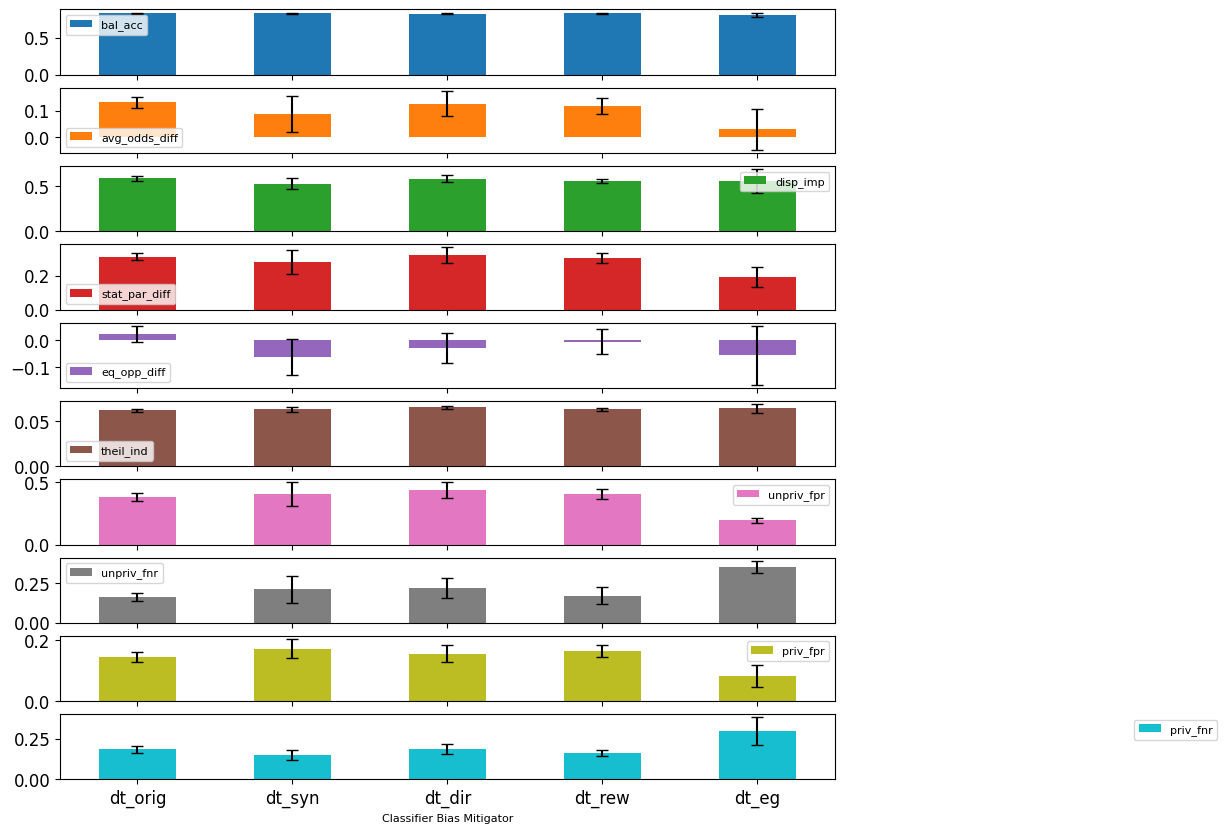

In [84]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        eg_metrics_mean]
#         pr_orig_metrics_mean,
#         cpp_metrics_mean,
#         ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        eg_error_metrics]
#         pr_orig_error_metrics,
#         cpp_error_metrics,
#         ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn'] + [model_type+'_dir'] + [model_type+'_rew'] + [model_type+'_eg'], name='Classifier Bias Mitigator')
#                   + [model_type+'_rew']+  + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [85]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [86]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.525186,0.514765,0.599913,0.557370,0.613195,0.513036,0.600004
syn,0.520042,0.511542,0.582379,0.555688,0.609047,0.509987,0.578630
dir,0.536305,0.530925,0.599013,0.576949,0.630464,0.529837,0.595295
rew,0.524627,0.514479,0.599600,0.562145,0.604072,0.512564,0.600766
eg,0.516617,0.510207,0.564117,0.562740,0.594409,0.508060,0.562383


In [87]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [88]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [89]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.557370,0.613195,0.513036,0.600004
syn,0.555688,0.609047,0.509987,0.578630
dir,0.576949,0.630464,0.529837,0.595295
rew,0.562145,0.604072,0.512564,0.600766
eg,0.562740,0.594409,0.508060,0.562383


<Axes: xlabel='Classifier MIA Attacks'>

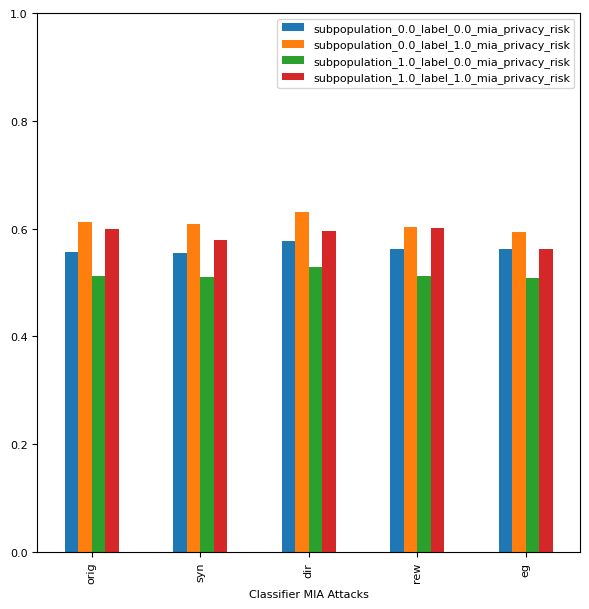

In [90]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [91]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.55737   0.555688  0.576949  0.562145  0.56274
subpopulation_0.0_label_1.0_mia_privacy_risk  0.613195  0.609047  0.630464  0.604072  0.594409
subpopulation_1.0_label_0.0_mia_privacy_risk  0.513036  0.509987  0.529837  0.512564  0.50806
subpopulation_1.0_label_1.0_mia_privacy_risk  0.600004  0.57863   0.595295  0.600766  0.562383


### Visualizing using novel technique

In [131]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [132]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [133]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.514216
1,orig,entire_dataset_mia_privacy_risk,0.513086
2,orig,entire_dataset_mia_privacy_risk,0.514701
3,orig,entire_dataset_mia_privacy_risk,0.516963
4,orig,entire_dataset_mia_privacy_risk,0.516963
...,...,...,...
495,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.631252
496,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.618696
497,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.631888
498,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.624218


In [134]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.514216
1,orig,entire_dataset_mia_privacy_risk,0.513086
2,orig,entire_dataset_mia_privacy_risk,0.514701
3,orig,entire_dataset_mia_privacy_risk,0.516963
4,orig,entire_dataset_mia_privacy_risk,0.516963
...,...,...,...
495,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.631252
496,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.618696
497,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.631888
498,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.624218


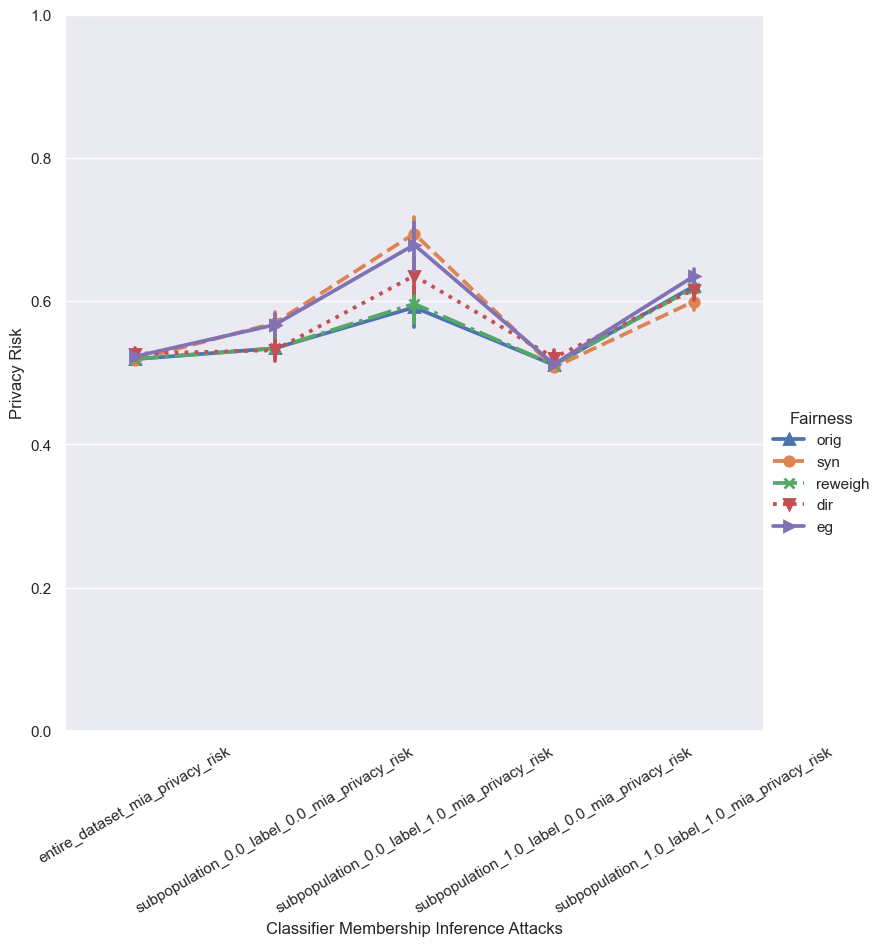

In [135]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [136]:
from sklearn.metrics import RocCurveDisplay, auc

In [137]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0.0_label_1.0_mia_result', 'subpopulation_1.0_label_0.0_mia_auc', 'subpopulation_1.0_label_0.0_mia_privacy_risk', 'subpopulation_1.0_label_0.0_mia_ppv', 'subpopulation_1.0_label_0.0_mia_attacker_advantage', 'subpopulation_1.0_label_0.0_mia_result', 'subpopulation_1.0_label_1.0_mia_auc', 'subpopulation_1.0_label_1.0_mia_privacy_risk', 'subpopulation_1.0_label_1.0_mia_ppv', 'subpopulation_1.0_label_1.0_mia_attacke

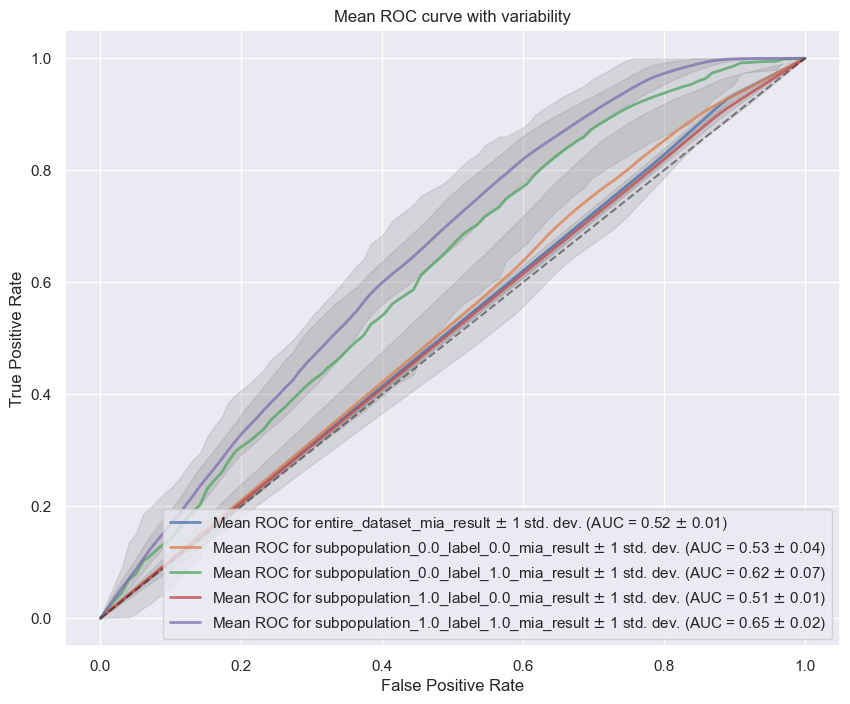

In [138]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3095, Test = 3095
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: [0.6061358]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3095, Test = 3095
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: [0.6061358]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3095, Test = 3095
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3095, Test = 3095
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Tr

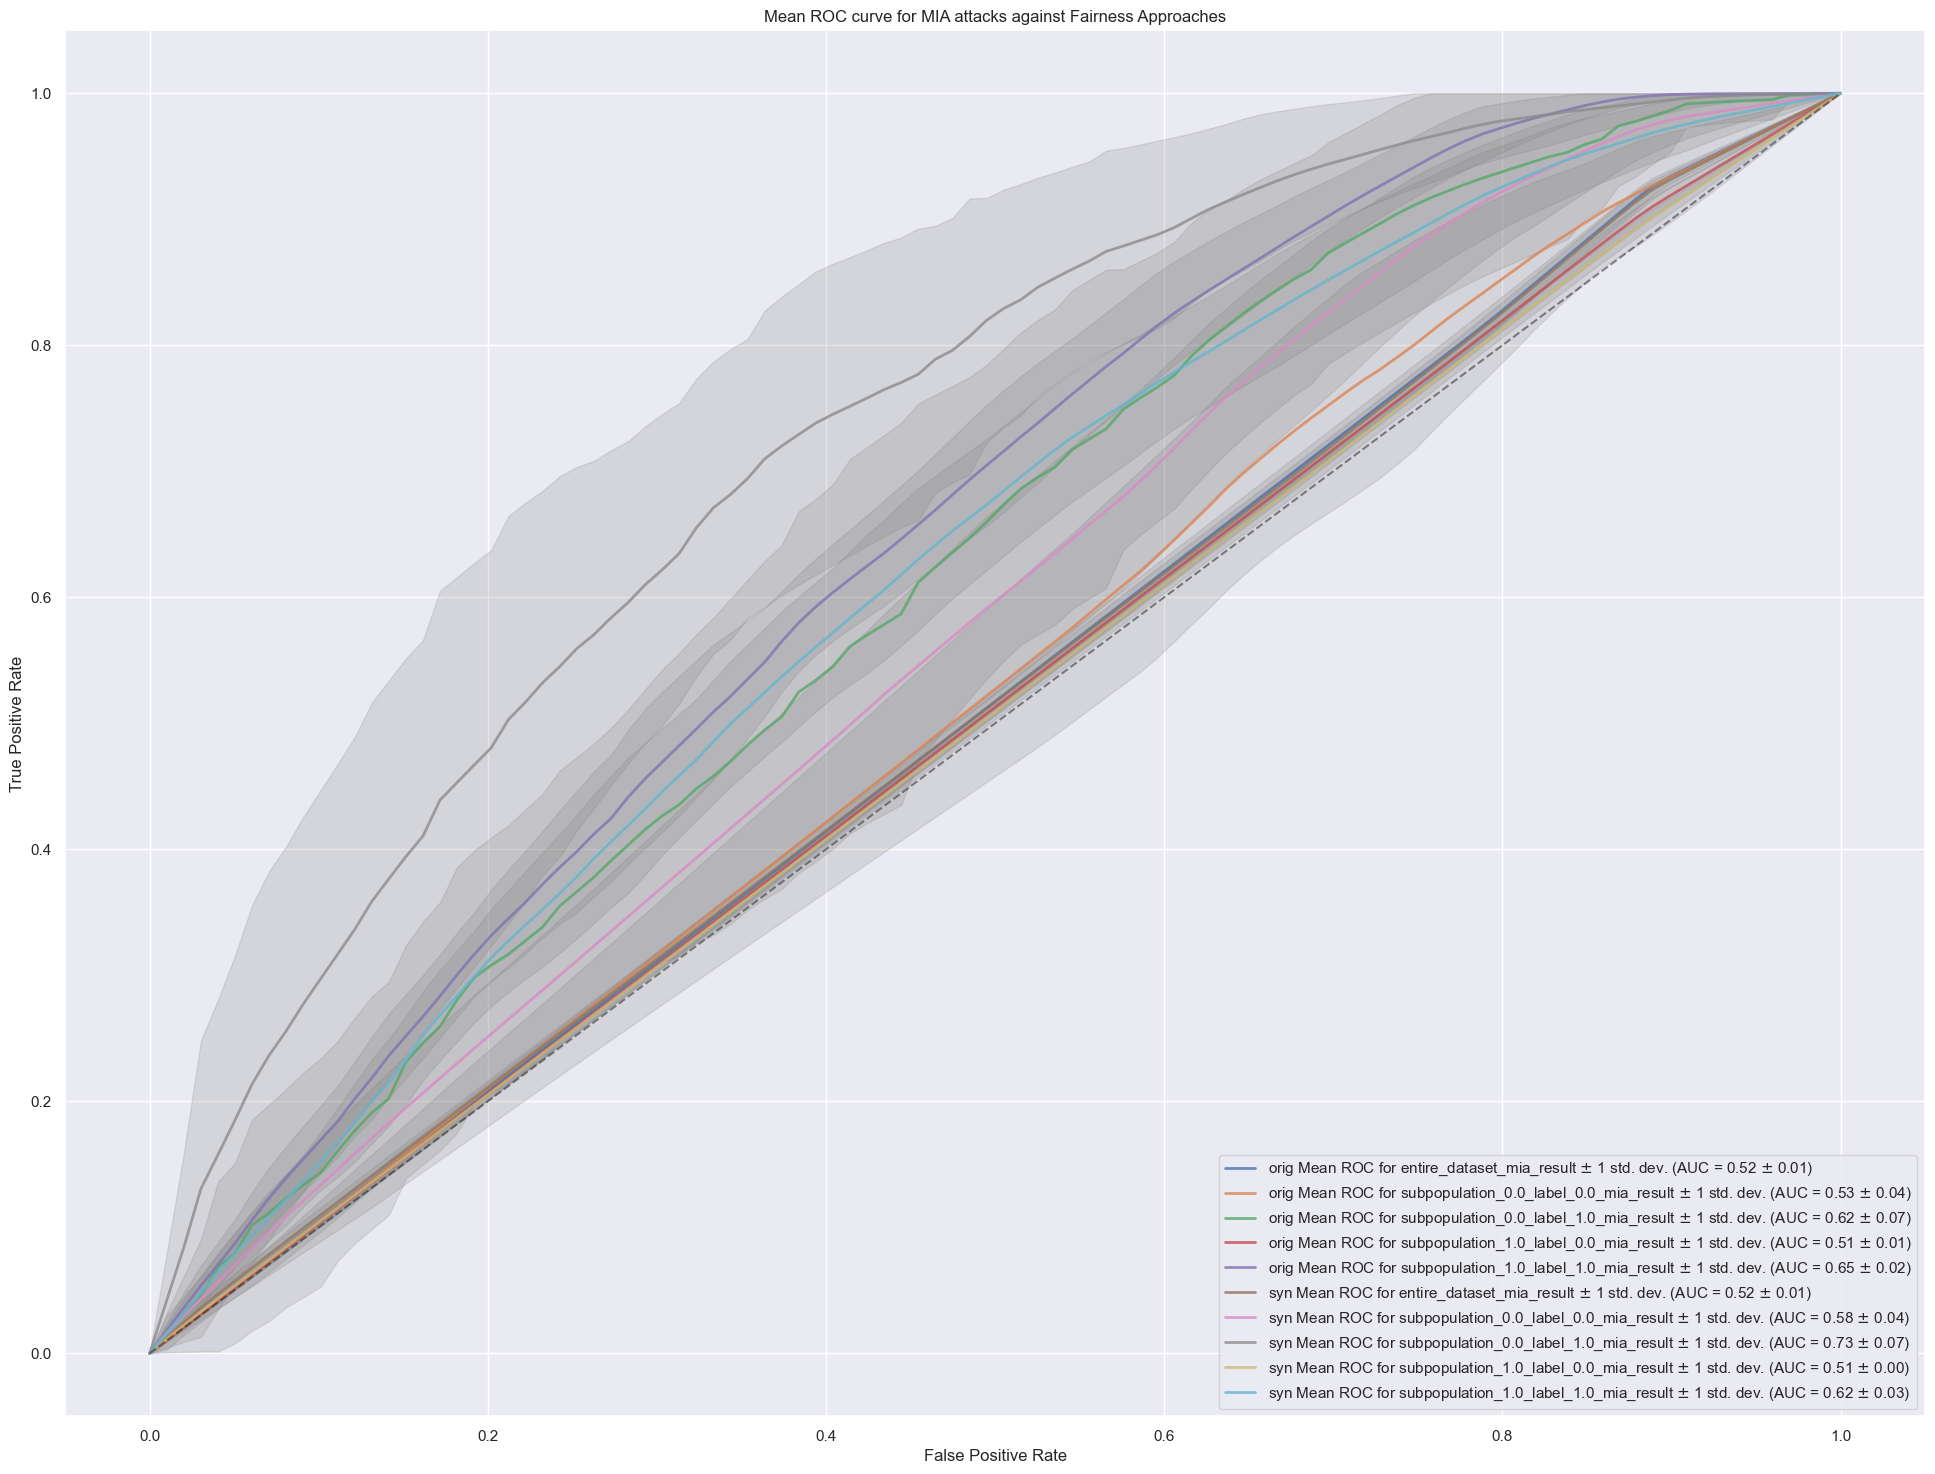

In [139]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

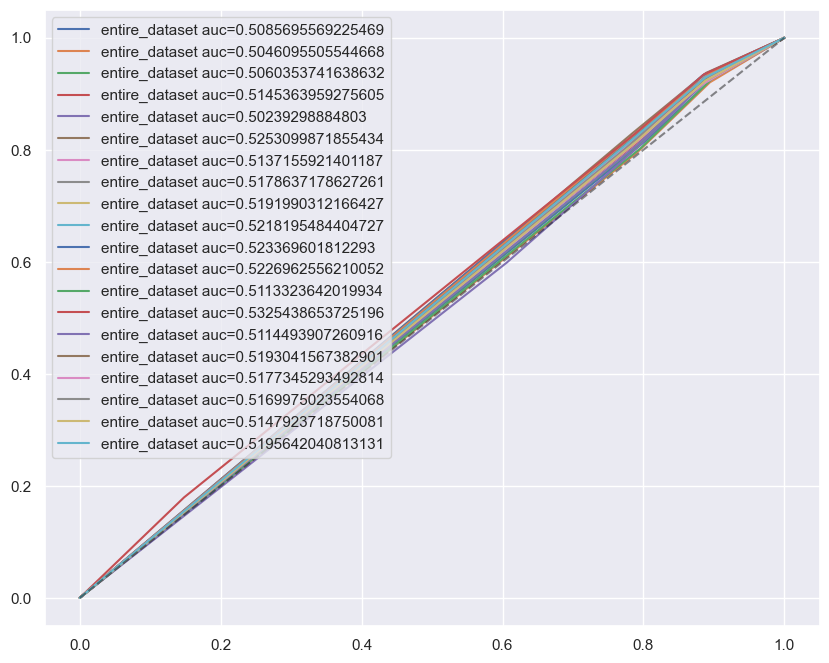

In [140]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [141]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [142]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5161917992697587,
 'subpopulation_0.0_label_0.0_mia_auc': 0.5262779498256818,
 'subpopulation_0.0_label_1.0_mia_auc': 0.6160106041085894,
 'subpopulation_1.0_label_0.0_mia_auc': 0.5112421073859792,
 'subpopulation_1.0_label_1.0_mia_auc': 0.6475413566434628}

In [143]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,
orig,0.516192,0.526278,0.616011,0.511242,0.647541
syn,0.516568,0.578056,0.731124,0.507986,0.618620
dir,0.522263,0.540329,0.656143,0.519476,0.636083
rew,0.516570,0.526096,0.615941,0.511120,0.647959
egr,0.514949,0.555659,0.706799,0.508973,0.672587


<Axes: xlabel='Classifier MIA Attacks'>

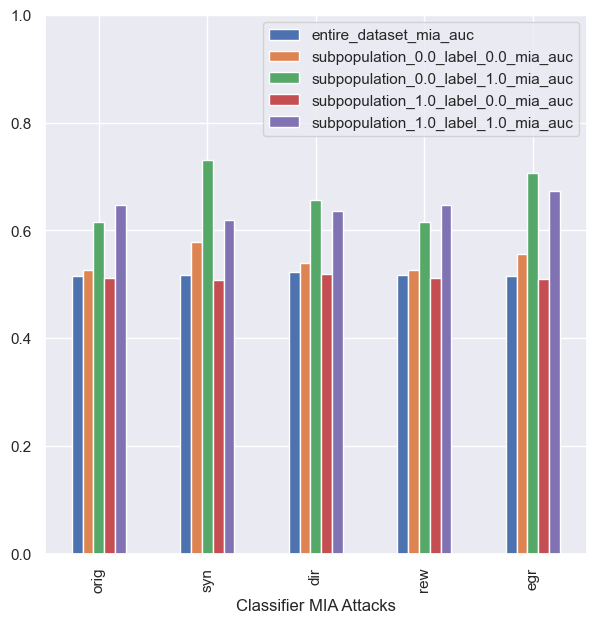

In [144]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [145]:
# Creating data structures to plot point categorical plot from seaborn

In [146]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [147]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.02843295638126009,
  0.02617124394184167,
  0.029402261712439426,
  0.03392568659127626,
  0.03392568659127626,
  0.0484652665589661,
  0.03295638126009692,
  0.048788368336025845,
  0.03521809369951545,
  0.04846526655896599,
  0.048788368336025845,
  0.04264943457189008,
  0.03812600969305324,
  0.048788368336025845,
  0.0348949919224556,
  0.035541195476575194,
  0.033279483037156665,
  0.04168012924071085,
  0.035541195476575194,
  0.04135702746365111],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.08889289578074289,
  0.07975077881619941,
  0.07296964093080593,
  0.0317543859649122,
  0.1492837598583615,
  0.07277628032345018,
  0.20007166746297178,
  0.09721295060080104,
  0.10964212445862775,
  0.16857360793287568,
  0.08857906161295714,
  0.056260869565217364,
  0.12767644726407612,
  0.16638029782359687,
  0.11979595194997528,
  0.08677685950413228,
  0.08871026671538174,
  0.13135727908455175,
  0.02926601215521274,
  0

In [148]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.02843295638126009],
 ['orig', 'entire_dataset', 0.02617124394184167],
 ['orig', 'entire_dataset', 0.029402261712439426],
 ['orig', 'entire_dataset', 0.03392568659127626],
 ['orig', 'entire_dataset', 0.03392568659127626],
 ['orig', 'entire_dataset', 0.0484652665589661],
 ['orig', 'entire_dataset', 0.03295638126009692],
 ['orig', 'entire_dataset', 0.048788368336025845],
 ['orig', 'entire_dataset', 0.03521809369951545],
 ['orig', 'entire_dataset', 0.04846526655896599],
 ['orig', 'entire_dataset', 0.048788368336025845],
 ['orig', 'entire_dataset', 0.04264943457189008],
 ['orig', 'entire_dataset', 0.03812600969305324],
 ['orig', 'entire_dataset', 0.048788368336025845],
 ['orig', 'entire_dataset', 0.0348949919224556],
 ['orig', 'entire_dataset', 0.035541195476575194],
 ['orig', 'entire_dataset', 0.033279483037156665],
 ['orig', 'entire_dataset', 0.04168012924071085],
 ['orig', 'entire_dataset', 0.035541195476575194],
 ['orig', 'entire_dataset', 0.041357027463651

In [149]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.028433
1,orig,entire_dataset,0.026171
2,orig,entire_dataset,0.029402
3,orig,entire_dataset,0.033926
4,orig,entire_dataset,0.033926
...,...,...,...
495,egr,subpopulation_1.0_label_1.0,0.262504
496,egr,subpopulation_1.0_label_1.0,0.237393
497,egr,subpopulation_1.0_label_1.0,0.263776
498,egr,subpopulation_1.0_label_1.0,0.252439


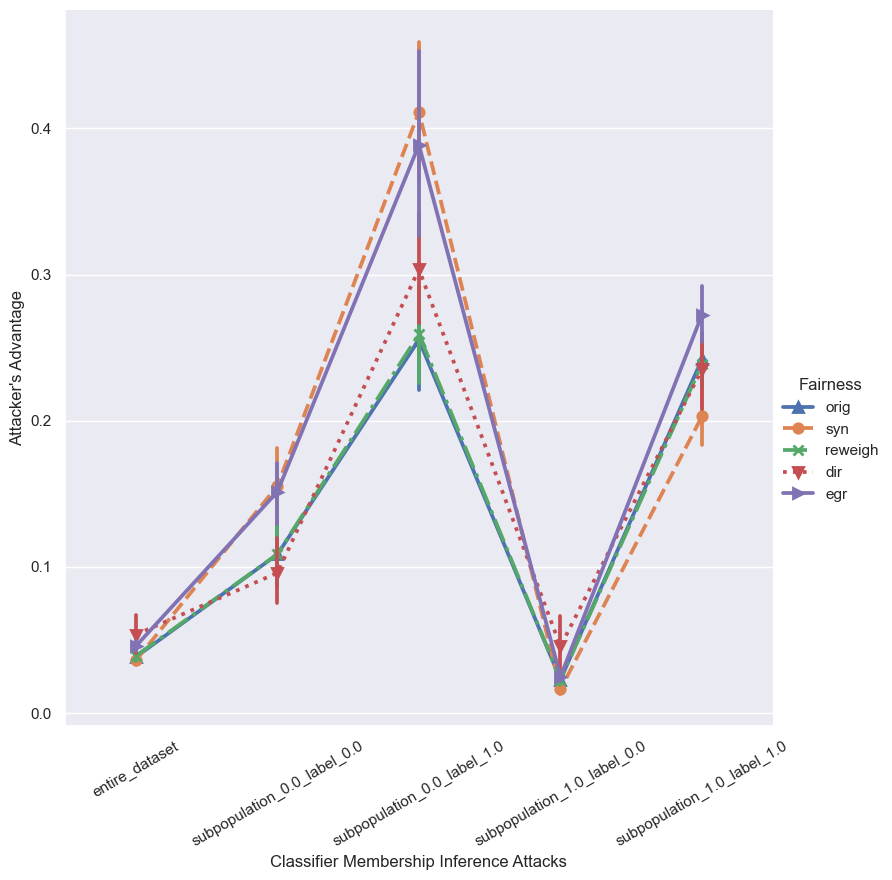

In [150]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


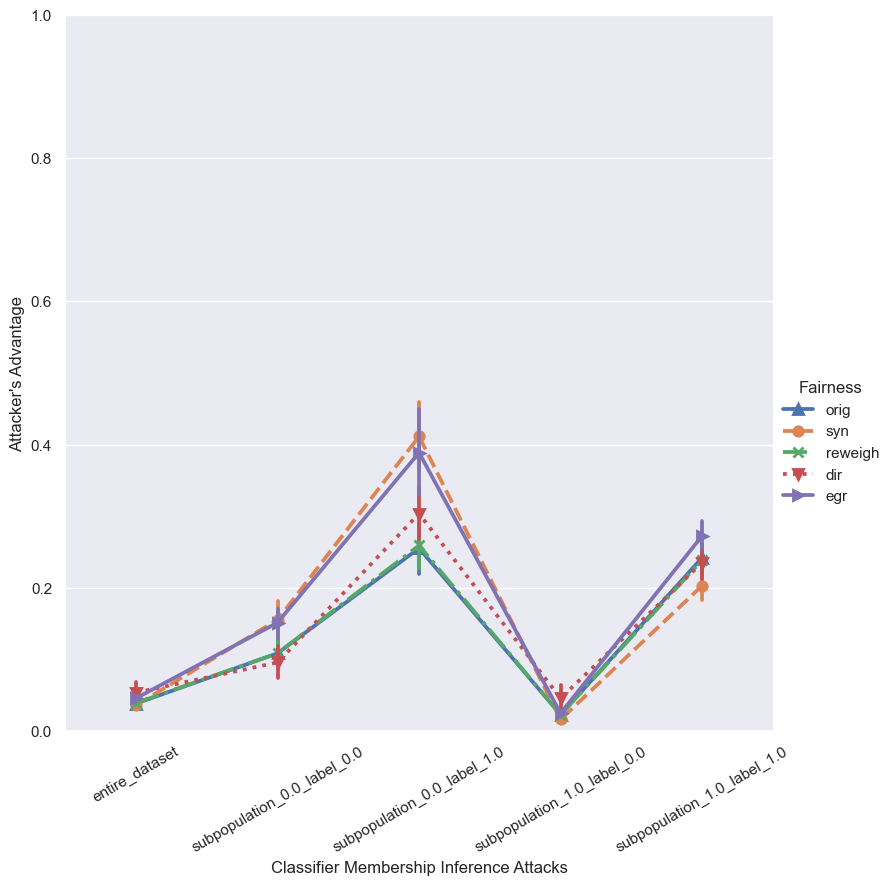

In [151]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [152]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.028433,0.088893,0.178709,0.012244,0.241315
1,0.026171,0.079751,0.221138,0.012056,0.220018
2,0.029402,0.072970,0.283333,0.017426,0.271522
3,0.033926,0.031754,0.367896,0.015077,0.237060
4,0.033926,0.149284,0.191388,0.018996,0.221615
5,0.048465,0.072776,0.272866,0.029721,0.290491
6,0.032956,0.200072,0.197222,0.017032,0.174315
7,0.048788,0.097213,0.337963,0.032542,0.341564
8,0.035218,0.109642,0.303030,0.026681,0.181021
9,0.048465,0.168574,0.256410,0.023037,0.305992


In [153]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [154]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.03831987075928918,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.10852125683082478,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.25531821713444136,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.02288220104376299,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.2421393932649642}

In [155]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,
orig,0.038320,0.108521,0.255318,0.022882,0.242139
syn,0.036058,0.155337,0.411382,0.016207,0.203002
dir,0.053635,0.095869,0.303646,0.045634,0.235104
rew,0.039031,0.108699,0.259140,0.022824,0.238970
egr,0.045751,0.151367,0.388738,0.024859,0.272556


<Axes: xlabel='Classifier MIA Attacks'>

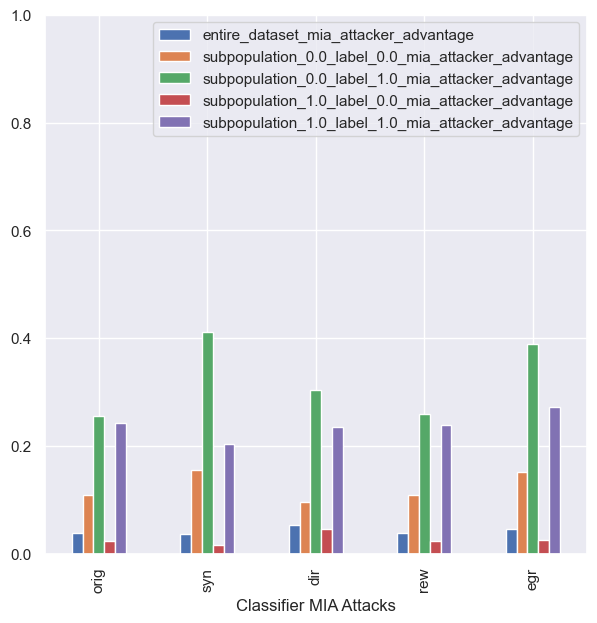

In [156]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [157]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [158]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5078208318521151],
 ['orig', 'entire_dataset', 0.5072102545842976],
 ['orig', 'entire_dataset', 0.5080630870104554],
 ['orig', 'entire_dataset', 0.5093632958801498],
 ['orig', 'entire_dataset', 0.5093699803676602],
 ['orig', 'entire_dataset', 0.514],
 ['orig', 'entire_dataset', 0.5091430620294013],
 ['orig', 'entire_dataset', 0.5134222222222222],
 ['orig', 'entire_dataset', 0.5108760726401916],
 ['orig', 'entire_dataset', 0.5134264232008593],
 ['orig', 'entire_dataset', 0.5137111517367459],
 ['orig', 'entire_dataset', 0.5125709651257097],
 ['orig', 'entire_dataset', 0.5104647037956722],
 ['orig', 'entire_dataset', 0.5478775913129319],
 ['orig', 'entire_dataset', 0.5095676824946846],
 ['orig', 'entire_dataset', 0.5108783239323126],
 ['orig', 'entire_dataset', 0.509883017345704],
 ['orig', 'entire_dataset', 0.511507582515611],
 ['orig', 'entire_dataset', 0.5098074179743224],
 ['orig', 'entire_dataset', 0.511379800853485],
 ['orig', 'subpopulation_0.0_label_0

In [159]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.507821
1,orig,entire_dataset,0.507210
2,orig,entire_dataset,0.508063
3,orig,entire_dataset,0.509363
4,orig,entire_dataset,0.509370
...,...,...,...
495,egr,subpopulation_1.0_label_1.0,0.672414
496,egr,subpopulation_1.0_label_1.0,0.666667
497,egr,subpopulation_1.0_label_1.0,0.633663
498,egr,subpopulation_1.0_label_1.0,0.750000


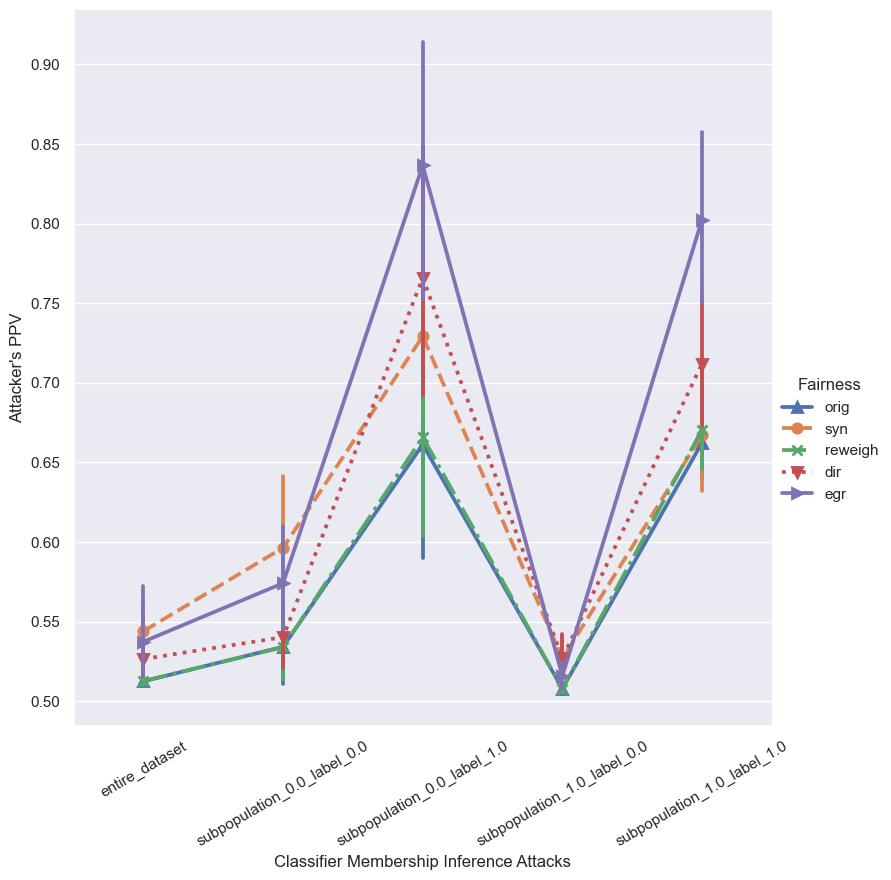

In [160]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [161]:
import pandas as pd

In [162]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25791,1.0,281.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25792,0.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25793,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25794,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [163]:
df[["age", "labels"]].value_counts(normalize=True)

age  labels
1.0  0.0       0.865793
1.0  1.0       0.088231
0.0  0.0       0.034540
0.0  1.0       0.011436
Name: proportion, dtype: float64

In [164]:
df.drop_duplicates()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25791,1.0,281.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25792,0.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
25793,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25794,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## DT Accuracy

In [165]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER, ATTACK)

[INFO]: training decision tree
Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97       102
         1.0       0.00      0.00      0.00         0

    accuracy                           0.95       102
   macro avg       0.50      0.48      0.49       102
weighted avg       1.00      0.95      0.97       102

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.67      0.81        43

    accuracy                           0.67        43
   macro avg       0.50      0.34      0.40        43
weighted avg       1.00      0.67      0.81        43

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2648
         1.0       0.00      0.00      0.00         0

    accuracy                           0.98      

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'train_0_0': 0.9509803921568627,
 'train_0_1': 0.6744186046511628,
 'train_1_0': 0.9811178247734139,
 'train_1_1': 0.6258278145695364,
 'test_0_0': 0.8181818181818182,
 'test_0_1': 0.5652173913043478,
 'test_1_0': 0.9501661129568106,
 'test_1_1': 0.5}

In [166]:
# train_test_egr